In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from cosmic.evolve import Evolve
from cosmic.sample.initialbinarytable import InitialBinaryTable
import pandas as pd

In [2]:
time_bins = np.logspace(0, np.log10(1000), 15)

In [3]:
def select_WR(bpp_in, WR_mass_min=5.0):
    WR_1_start = bpp_in.loc[(bpp_in.kstar_1.isin([7,8,9])) & (bpp_in.mass_1 >= WR_mass_min)].groupby('bin_num', as_index=False).first()
    WR_2_start = bpp_in.loc[(bpp_in.kstar_2.isin([7,8,9])) & (bpp_in.mass_2 >= WR_mass_min)].groupby('bin_num', as_index=False).first()

    WR_1_end = bpp_in.loc[(bpp_in.evol_type == 15)]
    WR_2_end = bpp_in.loc[(bpp_in.evol_type == 16)]

    return WR_1_start, WR_1_end, WR_2_start, WR_2_end

#4300 - 3150

def select_RSG(bcm_in, teff_lo=3150, lum_lo=4300, lum_hi=10**5.5):
    RSG_1_start = bcm_in.loc[(bcm_in.teff_1 <= teff_lo) & (bcm_in.lum_1 > lum_lo) & (bcm_in.lum_1 < lum_hi)].groupby('bin_num', as_index=False).first()
    RSG_2_start = bcm_in.loc[(bcm_in.teff_2 <= teff_lo) & (bcm_in.lum_2 > lum_lo) & (bcm_in.lum_2 < lum_hi)].groupby('bin_num', as_index=False).first()

    RSG_1_end = bcm_in.loc[(bcm_in.teff_1 <= teff_lo) & (bcm_in.lum_1 > lum_lo) & (bcm_in.lum_1 < lum_hi)].groupby('bin_num', as_index=False).last()
    RSG_2_end = bcm_in.loc[(bcm_in.teff_2 <= teff_lo) & (bcm_in.lum_2 > lum_lo) & (bcm_in.lum_2 < lum_hi)].groupby('bin_num', as_index=False).last()

    return RSG_1_start, RSG_1_end, RSG_2_start, RSG_2_end

def select_delay_times(start_1, end_1, start_2, end_2, time_bins):
    select_1 = []
    bn_select_1 = []
    select_2 = []
    bn_select_2 = []
    for t_lo, t_hi in zip(time_bins[:-1], time_bins[1:]):
        bn_start = start_1.loc[start_1.tphys >= t_lo].bin_num.values
        bn_end = end_1.loc[end_1.tphys <= t_hi].bin_num.values
        bn_in_bin = np.intersect1d(bn_start, bn_end)
    
        select_1.append(start_1.loc[start_1.bin_num.isin(bn_in_bin)])
        bn_select_1.append(bn_in_bin)
    
        bn_start_2 = start_2.loc[start_2.tphys >= t_lo].bin_num.values
        bn_end_2 = end_2.loc[end_2.tphys <= t_hi].bin_num.values
        bn_in_bin_2 = np.intersect1d(bn_start_2, bn_end_2)
    
        select_2.append(start_2.loc[start_2.bin_num.isin(bn_start_2)])
        bn_select_2.append(bn_in_bin_2)
    
    n_select_1 = []
    for bn in bn_select_1:
        n_select_1.append(len(bn))
    
    n_select_1 = np.array(n_select_1)
    
    n_select_2 = []
    for bn in bn_select_2:
        n_select_2.append(len(bn))
    
    n_select_2 = np.array(n_select_2)
    
    return select_1, select_2, n_select_1, n_select_2

In [4]:
def get_delay_times(bpp_in, bcm_in):
    WR_1_start, WR_2_start, WR_1_end, WR_2_end = select_WR(bpp_in)
    RSG_1_start, RSG_1_end, RSG_2_start, RSG_2_end = select_RSG(bcm_in)
        
    WR_select_1, WR_select_2, WR_n_select_1, WR_n_select_2 = select_delay_times(WR_1_start, WR_1_end, WR_2_start, WR_2_end, time_bins)
    RSG_select_1, RSG_select_2, RSG_n_select_1, RSG_n_select_2 = select_delay_times(RSG_1_start, RSG_1_end, RSG_2_start, RSG_2_end, time_bins)

    select_1 = [WR_select_1, RSG_select_1]
    select_2 = [WR_select_2, RSG_select_2]

    n_select_1 = [WR_n_select_1, RSG_n_select_1]
    n_select_2 = [WR_n_select_2, RSG_n_select_2]
    return select_1, select_2, n_select_1, n_select_2

In [5]:
InitialBinaries, mass_singles, mass_binaries, n_singles, n_binaries = InitialBinaryTable.sampler(
    'independent', [13,14], [13,14], binfrac_model=0.5, primary_model='kroupa01', 
    ecc_model='sana12', porb_model='sana12', m2_min=0.08, SF_start=13700.0, SF_duration=0.0, 
    met=0.02, size=20000, keep_singles=True)

In [29]:
BSEDict = {'xi': 0.5, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 1.0, 'pts1': 0.05, 
           'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 
           'lambdaf': 0.0, 'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag' : 1, 'remnantflag': 4, 
           'ceflag': 1, 'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265, 'gamma': -2.0, 'pisn': -2, 
           'natal_kick_array' : [[-100.0,-100.0,-100.0,-100.0,0.0], [-100.0,-100.0,-100.0,-100.0,0.0]], 
           'bhsigmafrac' : 1.0, 'polar_kick_angle' : 90, 
           'qcrit_array' : [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], 
           'cekickflag' : 2, 'cehestarflag' : 0, 'cemergeflag' : 1, 'ecsn' : 2.25, 'ecsn_mlow' : 1.6, 'aic' : 1, 
           'ussn' : 1, 'sigmadiv' :-20.0, 'qcflag' : 5, 'eddlimflag' : 0, 
           'fprimc_array' : [2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,
                             2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0], 
           'bhspinflag' : 0, 'bhspinmag' : 0.0, 'rejuv_fac' : 1.0, 'rejuvflag' : 0, 'htpmb' : 1, 'ST_cr' : 0, 'ST_tide' : 0, 
           'bdecayfac' : 1, 'rembar_massloss' : 0.5, 'kickflag' : 0, 'zsun' : 0.02, 'bhms_coll_flag' : 0, 
           'don_lim' : -1, 'acc_lim' : -1, 'rtmsflag':0, 'wd_mass_lim' : 1}

#BSEDict_alpha_lo =  {'xi': 0.5, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 0.5, 'pts1': 0.05, 
#           'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 
#           'lambdaf': 0.0, 'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag' : 1, 'remnantflag': 4, 
#           'ceflag': 1, 'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265, 'gamma': -2.0, 'pisn': -2, 
#           'natal_kick_array' : [[-100.0,-100.0,-100.0,-100.0,0.0], [-100.0,-100.0,-100.0,-100.0,0.0]], 
#           'bhsigmafrac' : 1.0, 'polar_kick_angle' : 90, 
#           'qcrit_array' : [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], 
#           'cekickflag' : 2, 'cehestarflag' : 0, 'cemergeflag' : 1, 'ecsn' : 2.25, 'ecsn_mlow' : 1.6, 'aic' : 1, 
#           'ussn' : 1, 'sigmadiv' :-20.0, 'qcflag' : 5, 'eddlimflag' : 0, 
#           'fprimc_array' : [2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,
#                             2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0], 
#           'bhspinflag' : 0, 'bhspinmag' : 0.0, 'rejuv_fac' : 1.0, 'rejuvflag' : 0, 'htpmb' : 1, 'ST_cr' : 0, 'ST_tide' : 0, 
#           'bdecayfac' : 1, 'rembar_massloss' : 0.5, 'kickflag' : 0, 'zsun' : 0.02, 'bhms_coll_flag' : 0, 
#           'don_lim' : -1, 'acc_lim' : -1, 'rtmsflag':0, 'wd_mass_lim' : 1}
#
BSEDict_acclim_lo =  {'xi': 0.5, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 0.5, 'pts1': 0.05, 
           'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 
           'lambdaf': 0.0, 'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag' : 1, 'remnantflag': 4, 
           'ceflag': 1, 'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265, 'gamma': -2.0, 'pisn': -2, 
           'natal_kick_array' : [[-100.0,-100.0,-100.0,-100.0,0.0], [-100.0,-100.0,-100.0,-100.0,0.0]], 
           'bhsigmafrac' : 1.0, 'polar_kick_angle' : 90, 
           'qcrit_array' : [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], 
           'cekickflag' : 2, 'cehestarflag' : 0, 'cemergeflag' : 1, 'ecsn' : 2.25, 'ecsn_mlow' : 1.6, 'aic' : 1, 
           'ussn' : 1, 'sigmadiv' :-20.0, 'qcflag' : 5, 'eddlimflag' : 0, 
           'fprimc_array' : [2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,
                             2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0], 
           'bhspinflag' : 0, 'bhspinmag' : 0.0, 'rejuv_fac' : 1.0, 'rejuvflag' : 0, 'htpmb' : 1, 'ST_cr' : 0, 'ST_tide' : 0, 
           'bdecayfac' : 1, 'rembar_massloss' : 0.5, 'kickflag' : 0, 'zsun' : 0.02, 'bhms_coll_flag' : 0, 
           'don_lim' : -1, 'acc_lim' : 0.5, 'rtmsflag':0, 'wd_mass_lim' : 1}

BSEDict_acclim_no =  {'xi': 0.5, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 0.5, 'pts1': 0.05, 
           'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 
           'lambdaf': 0.0, 'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag' : 1, 'remnantflag': 4, 
           'ceflag': 1, 'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265, 'gamma': -2.0, 'pisn': -2, 
           'natal_kick_array' : [[-100.0,-100.0,-100.0,-100.0,0.0], [-100.0,-100.0,-100.0,-100.0,0.0]], 
           'bhsigmafrac' : 1.0, 'polar_kick_angle' : 90, 
           'qcrit_array' : [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], 
           'cekickflag' : 2, 'cehestarflag' : 0, 'cemergeflag' : 1, 'ecsn' : 2.25, 'ecsn_mlow' : 1.6, 'aic' : 1, 
           'ussn' : 1, 'sigmadiv' :-20.0, 'qcflag' : 5, 'eddlimflag' : 0, 
           'fprimc_array' : [2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,
                             2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0], 
           'bhspinflag' : 0, 'bhspinmag' : 0.0, 'rejuv_fac' : 1.0, 'rejuvflag' : 0, 'htpmb' : 1, 'ST_cr' : 0, 'ST_tide' : 0, 
           'bdecayfac' : 1, 'rembar_massloss' : 0.5, 'kickflag' : 0, 'zsun' : 0.02, 'bhms_coll_flag' : 0, 
           'don_lim' : -1, 'acc_lim' : 0.0, 'rtmsflag':0, 'wd_mass_lim' : 1}
#SSEDict = {'stellar_engine' : 'sse'}
#

In [7]:
#bpp, bcm, initC, kick_info  = Evolve.evolve(initialbinarytable=InitialBinaries, BSEDict=BSEDict, nproc=3, timestep_conditions =[['kstar_1 <= 10', 'mass_1 > 7.0', 'dtp=0.1'], ['kstar_2 <= 10', 'mass_1 > 7.0', 'dtp=0.1']])

In [8]:
#bpp.to_hdf('alpha_1_dat.h5', key='bpp')
#bcm.to_hdf('alpha_1_dat.h5', key='bcm')
#initC.to_hdf('alpha_1_dat.h5', key='initC')
#kick_info.to_hdf('alpha_1_dat.h5', key='kick_info')

In [9]:
bpp = []
bcm = []
initC = []
kick_info = []

In [10]:
#bpp_alpha_lo, bcm_alpha_lo, initC_alpha_lo, kick_info_alpha_lo  = Evolve.evolve(initialbinarytable=InitialBinaries, BSEDict=BSEDict_alpha_lo, nproc=3,  timestep_conditions =[['kstar_1 <= 10', 'mass_1 > 7.0', 'dtp=0.1'], ['kstar_2 <= 10', 'mass_1 > 7.0', 'dtp=0.1']])

In [11]:
#bpp_alpha_lo.to_hdf('alpha_05_dat.h5', key='bpp')
#bcm_alpha_lo.to_hdf('alpha_05_dat.h5', key='bcm')
#initC_alpha_lo.to_hdf('alpha_05_dat.h5', key='initC')
#kick_info_alpha_lo.to_hdf('alpha_05_dat.h5', key='kick_info')

In [12]:
#bpp_alpha_lo = []
#bcm_alpha_lo = []
#initC_alpha_lo = []
#kick_info_alpha_lo = []

In [13]:
#bpp_acc_lim_lo, bcm_acc_lim_lo, initC_acc_lim_lo, kick_info_acc_lim_lo  = Evolve.evolve(initialbinarytable=InitialBinaries, BSEDict=BSEDict_acclim_lo, nproc=3, timestep_conditions =[['kstar_1 <= 10', 'mass_1 > 7.0', 'dtp=0.1'], ['kstar_2 <= 10', 'mass_1 > 7.0', 'dtp=0.1']])

In [14]:
#bpp_acc_lim_lo.to_hdf('acc_lim_05_dat.h5', key='bpp')
#bcm_acc_lim_lo.to_hdf('acc_lim_05_dat.h5', key='bcm')
#initC_acc_lim_lo.to_hdf('acc_lim_05_dat.h5', key='initC')
#kick_info_acc_lim_lo.to_hdf('acc_lim_05_dat.h5', key='kick_info')

In [15]:
bpp_acc_lim_lo = []
bcm_acc_lim_lo = []
initC_acc_lim_lo = []
kick_info_acc_lim_lo = []

In [30]:
bpp_acc_lim_no, bcm_acc_lim_no, initC_acc_lim_no, kick_info_acc_lim_no  = Evolve.evolve(initialbinarytable=InitialBinaries, BSEDict=BSEDict_acclim_no, nproc=3, timestep_conditions =[['kstar_1 <= 10', 'mass_1 > 7.0', 'dtp=0.1'], ['kstar_2 <= 10', 'mass_1 > 7.0', 'dtp=0.1']])

In [31]:
bpp_acc_lim_no.to_hdf('acc_lim_no.h5', key='bpp')
bcm_acc_lim_no.to_hdf('acc_lim_no.h5', key='bcm')
initC_acc_lim_no.to_hdf('acc_lim_no.h5', key='initC')
kick_info_acc_lim_no.to_hdf('acc_lim_no.h5', key='kick_info')

In [32]:
select_1_acc_lim_no, select_2_acc_lim_no, n_select_1_acc_lim_no, n_select_2_acc_lim_no = get_delay_times(bpp_acc_lim_no, bcm_acc_lim_no)

In [16]:
#bpp_alpha_lo = pd.read_hdf('alpha_05_dat.h5', key='bpp')
#bcm_alpha_lo = pd.read_hdf('alpha_1_dat.h5', key='bcm')


In [17]:
#bpp_alpha_lo

In [18]:
#select_1_alpha_05, select_2_alpha_05, n_select_1_alpha_05, n_select_2_alpha_05 = get_delay_times(bpp_alpha_lo, bcm_alpha_lo)

In [19]:
#bpp_alpha_lo = []
#bcm_alpha_lo = []

In [20]:
bpp_alpha_hi = pd.read_hdf('alpha_1_dat.h5', key='bpp')
bcm_alpha_hi = pd.read_hdf('alpha_1_dat.h5', key='bcm')

In [21]:
select_1_alpha_1, select_2_alpha_1, n_select_1_alpha_1, n_select_2_alpha_1 = get_delay_times(bpp_alpha_hi, bcm_alpha_hi)

In [22]:
bpp_alpha_hi = []
bcm_alpha_hi = []

In [36]:
bpp_acc_lim_lo = pd.read_hdf('acc_lim_05_dat.h5', key='bpp')
bcm_acc_lim_lo = pd.read_hdf('acc_lim_05_dat.h5', key='bcm')

In [24]:
select_1_acc_lim_05, select_2_acc_lim_05, n_select_1_acc_lim_05, n_select_2_acc_lim_05 = get_delay_times(bpp_acc_lim_lo, bcm_acc_lim_lo)

In [25]:
bpp_acc_lim_lo = []
bcm_acc_lim_lo = []

In [26]:
#select_1_alpha_1, select_2_alpha_1, n_select_1_alpha_1, n_select_2_alpha_1 = get_delay_times(bpp_alpha_hi, bcm_alpha_hi)
#select_1_alpha_05, select_2_alpha_05, n_select_1_alpha_05, n_select_2_alpha_05 = get_delay_times(bpp_alpha_lo, bcm_alpha_lo)
#select_1_acc_lim_05, select_2_acc_lim_05, n_select_1_acc_lim_05, n_select_2_acc_lim_05 = get_delay_times(bpp_acc_lim_lo, bcm_acc_lim_lo)

[  0   0  90 202 127   0   0   0   0   0   0   0   0   0]
[   0    0    0    0   32   43   11 1005   66  172  173    0    0    0]
[  0   0 104 234 123   0   0   0   0   0   0   0   0   0]
[   0    0    0    1   35   43    8 1106  300  322  211    1    0    0]
[  0   0 223 310  39   0   0   0   0   0   0   0   0   0]
[   0    0    0    1   38   35   11 1185  311  333  218    5    0    0]


/var/folders/w7/h_b_mvnd5s53msxqvpnrsrw80000gn/T/ipykernel_29587/1121546709.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left')


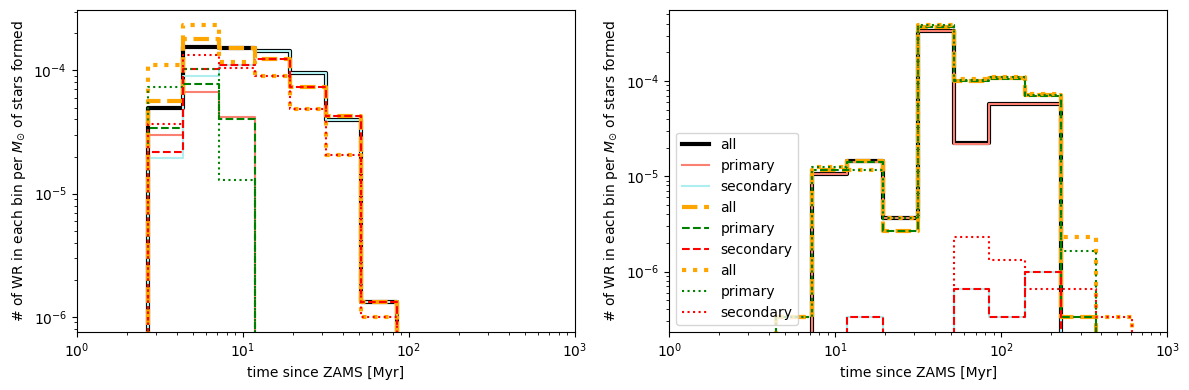

In [33]:
n_select_1_list = [n_select_1_alpha_1, #n_select_1_alpha_05, 
                   n_select_1_acc_lim_05,
                   n_select_1_acc_lim_no]
n_select_2_list = [n_select_2_alpha_1, #n_select_2_alpha_05, 
                   n_select_2_acc_lim_05,
                   n_select_2_acc_lim_no]

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(len(n_select_1_list[0])*6,4))
for ns1, ns2, ls in zip(n_select_1_list, n_select_2_list, ['-', '--', ':']):
    for ii, (n1, n2) in enumerate(zip(ns1, ns2)):
        print(n1)
        if ls=='-':
            axes[ii].plot(time_bins[1:], (n1 + n2)/(mass_singles + mass_binaries), drawstyle='steps', ls=ls, color='black', label='all', lw=3)
            axes[ii].plot(time_bins[1:], n1/(mass_singles + mass_binaries), drawstyle='steps', ls=ls, color='salmon', label='primary')
            axes[ii].plot(time_bins[1:], n2/(mass_singles + mass_binaries), drawstyle='steps', ls=ls, color='paleturquoise', label='secondary')

        else:
            axes[ii].plot(time_bins[1:], (n1 + n2)/(mass_singles + mass_binaries), drawstyle='steps', ls=ls, color='orange', label='all', lw=3)
            axes[ii].plot(time_bins[1:], n1/(mass_singles + mass_binaries), drawstyle='steps', ls=ls, color='green', label='primary')
            axes[ii].plot(time_bins[1:], n2/(mass_singles + mass_binaries), drawstyle='steps', ls=ls, color='red', label='secondary')

        plt.legend(loc='lower left')
        axes[ii].set_xlabel('time since ZAMS [Myr]')
        axes[ii].set_ylabel(r'# of WR in each bin per $M_{\odot}$ of stars formed')
        axes[ii].set_yscale('log')
        axes[ii].set_xscale('log')
        axes[ii].set_xlim(1, 1000)

plt.tight_layout()
plt.savefig('DTD_raw_counts.png', facecolor='white', dpi=120)

In [48]:
#select_1_acc_lim_no[1]

In [47]:
bpp_acc_lim_lo.loc[bpp_acc_lim_lo.bin_num.isin(select_1_acc_lim_no[1][4].bin_num.unique())].groupby('bin_num').first()

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,...,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2
bin_num,,,,,,,,,,,,,,,,,,,,,
1395,0.0,3.575374,3.468161,1.0,1.0,10.687978,1.525879,0.097339,0.592517,5.907003e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2573,0.0,7.289500,7.152208,1.0,1.0,98.669849,29.890939,0.325024,0.129184,1.288785e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3207,0.0,58.464513,13.908458,1.0,1.0,4383.599542,3953.941775,0.041994,0.005633,4.331615e-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3407,0.0,17.138092,10.041838,1.0,1.0,82.617447,16.693817,0.380342,0.250147,2.313044e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4571,0.0,5.916822,4.509129,1.0,1.0,235.958277,130.096959,0.691532,0.099027,9.600846e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5052,0.0,4.507107,3.491659,1.0,1.0,30019.309103,213138.407118,0.569519,0.000479,4.665137e-04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6536,0.0,29.283806,5.285846,1.0,1.0,32111.079681,113424.537245,0.677389,0.001389,1.073292e-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7423,0.0,14.405695,12.460326,1.0,1.0,645.440036,366.652234,0.291829,0.027413,2.683563e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7494,0.0,21.565990,3.899908,1.0,1.0,37.247701,5.220858,0.008135,0.321444,2.531875e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
time_bins = np.logspace(0, np.log10(300), 15)
plt.legend(loc='lower left')
plt.xlabel('time since ZAMS [Myr]')
plt.ylabel(r'# of WR in each bin per $M_{\odot}$ of stars formed')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1, 100)

plt.tight_layout()
plt.savefig('WR_raw_counts.png', facecolor='white', dpi=120)

In [ ]:
plt.plot(time_bins[1:], (n_select_1 + n_select_2)/(mass_singles + mass_binaries)/time_bins, drawstyle='steps', label='all', lw=2, color='black')
plt.plot(time_bins[1:], (n_select_1)/(mass_singles + mass_binaries)/time_bins, drawstyle='steps', label='primaries + singles')
plt.plot(time_bins[1:], (n_select_2)/(mass_singles + mass_binaries)/time_bins, drawstyle='steps', label='secondaries')
plt.legend(loc='lower left')
plt.xlabel('time since ZAMS [Myr]')
plt.ylabel(r'# of WR in each bin per $M_{\odot}$ of stars formed per time bin')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1, 100)

plt.tight_layout()
plt.savefig('WR_raw_counts.png', facecolor='white', dpi=120)